# Welcome to Passion!
Passion is a model that can detection anomaly using different methods (Both supervised and unsupervised) <br>

1. The goal for this project is to study the difference between different anomnaly detection model, and to   <br>
 find the state of art method for detecting anomaly in real world data<br>
2. Evaluate the results based on this :real server data+ https://www.kaggle.com/sohier/30-years-of-european-wind-generation (Unsupervised)+ https://github.com/numenta/NAB (Unsupervised+Supervised)  https://www.cs.ucr.edu/~eamonn/time_series_data/ (Supervised) <br>
3. Also use real data generated from server.
4. The model has the following fuctions: <br>
    a. Visualize the input data. Help the user to find critical features within the inputs. <br>
    b. Give user options to choose different models that are suitable for different circumstances. <br>
    c. Evaluate the performance based on the rules in this link https://github.com/numenta/NAB <br>
    d. Save model. Easy to be appplied to other dataset. <br>

5. Add un-labeled and labeled data






# What's new in version 8.1 

1. Add Transformer as a normal classifier (perfect:))
2. Add GAN and use the data generated to check whether it can "trick" the Transformer-classifier.
3. (Optional) Add Wavenet.


In [1]:
# import packages 


from matplotlib.pylab import rc
import torch
from scipy.stats import chisquare
from scipy.stats import pearsonr 
import pickle
import pandas as pd
import datetime
import matplotlib
import tensorflow as tf
import sklearn
import math
import matplotlib.pyplot as plt
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
import numpy as np
from sklearn.model_selection import train_test_split 
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder 
import copy
import scipy
import datetime
import time
import os
from sklearn.model_selection import KFold 
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import gc
import json
plot_path = "plots/"



In [2]:

# Real server data

root_path = "Data/Ant_202007/"


cif = pd.read_json(root_path+'cif.json', orient='index')
paycore = pd.read_json(root_path+'paycore.json', orient='index')
paydecision = pd.read_json(root_path+'paydecision.json', orient='index')
paydecision2 = pd.read_json(root_path+'paydecision2.json', orient='index')
paydecision3 = pd.read_json(root_path+'paydecision3.json', orient='index')

df = pd.DataFrame()
df["time_stamp"] = cif.index
df["cif"] = cif[0].values
df["paycore"] = paycore[0].values
df["paydecision"] = paydecision[0].values
df["paydecision2"] = paydecision2[0].values
df["paydecision3"] = paydecision3[0].values

# Optional
if False:
    df.to_csv(root_path+"fusion.csv")

    
# convert time stamp
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
names_array = np.array(df.keys()[1:],dtype="str")
os.listdir(root_path)





['.ipynb_checkpoints',
 'cif.json',
 'fusion.csv',
 'paycore.json',
 'paydecision.json',
 'paydecision2.json',
 'paydecision3.json']

In [3]:
if False:
    
    # calculate previous hour high low:
    # convert to seconds
    temp = df['time_stamp'] - min(df['time_stamp'])
    temp = temp.dt.total_seconds().astype(int)
    df["hours"] = temp//3600

    h_max = max(df["hours"])+1

    for n in range(len(names_array)):
        df[names_array[n]+"_open"] = df[names_array[n]]
        df[names_array[n]+"_close"] = df[names_array[n]]
        df[names_array[n]+"_max"] = df[names_array[n]]
        df[names_array[n]+"_min"] = df[names_array[n]]

    for j in range(1,h_max):
        mask_j = df["hours"]==j-1
        max_val = df[mask_j][names_array].max(axis=0).values
        min_val = df[mask_j][names_array].max(axis=0).values
        open_val = df[mask_j][names_array].values[0,:]
        close_val = df[mask_j][names_array].values[-1,:]
        mask_i = df["hours"]==j
        r = df[mask_i][names_array].shape[0]
        df.loc[mask_i,[r+"_open" for r in names_array]] = np.tile(open_val,(r,1))
        df.loc[mask_i,[r+"_close" for r in names_array]] = np.tile(close_val,(r,1))

        df.loc[mask_i,[r+"_max" for r in names_array]] = np.tile(max_val,(r,1))
        df.loc[mask_i,[r+"_min" for r in names_array]] = np.tile(min_val,(r,1))
    
    




In [4]:
# labeled data:
root_path2 = "Data/Ant_labeled/"

today = []
history = []
label = []
count=0
with open(root_path2+"train_data.txt") as f:
    for line in f:
        temp = json.loads(line)
        today.append(temp["today"])
        history.append(temp["history"])
        label.append(temp["label"])
        count+=1
today = np.array(today)
history = np.array(history)
label = np.array(label).ravel()

In [5]:



# For labeled data, we use today+history+diff to check them:
X = np.c_[today,history]
#X = np.atleast_3d(X)
# X = np.dstack((today,history))
y = label





findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


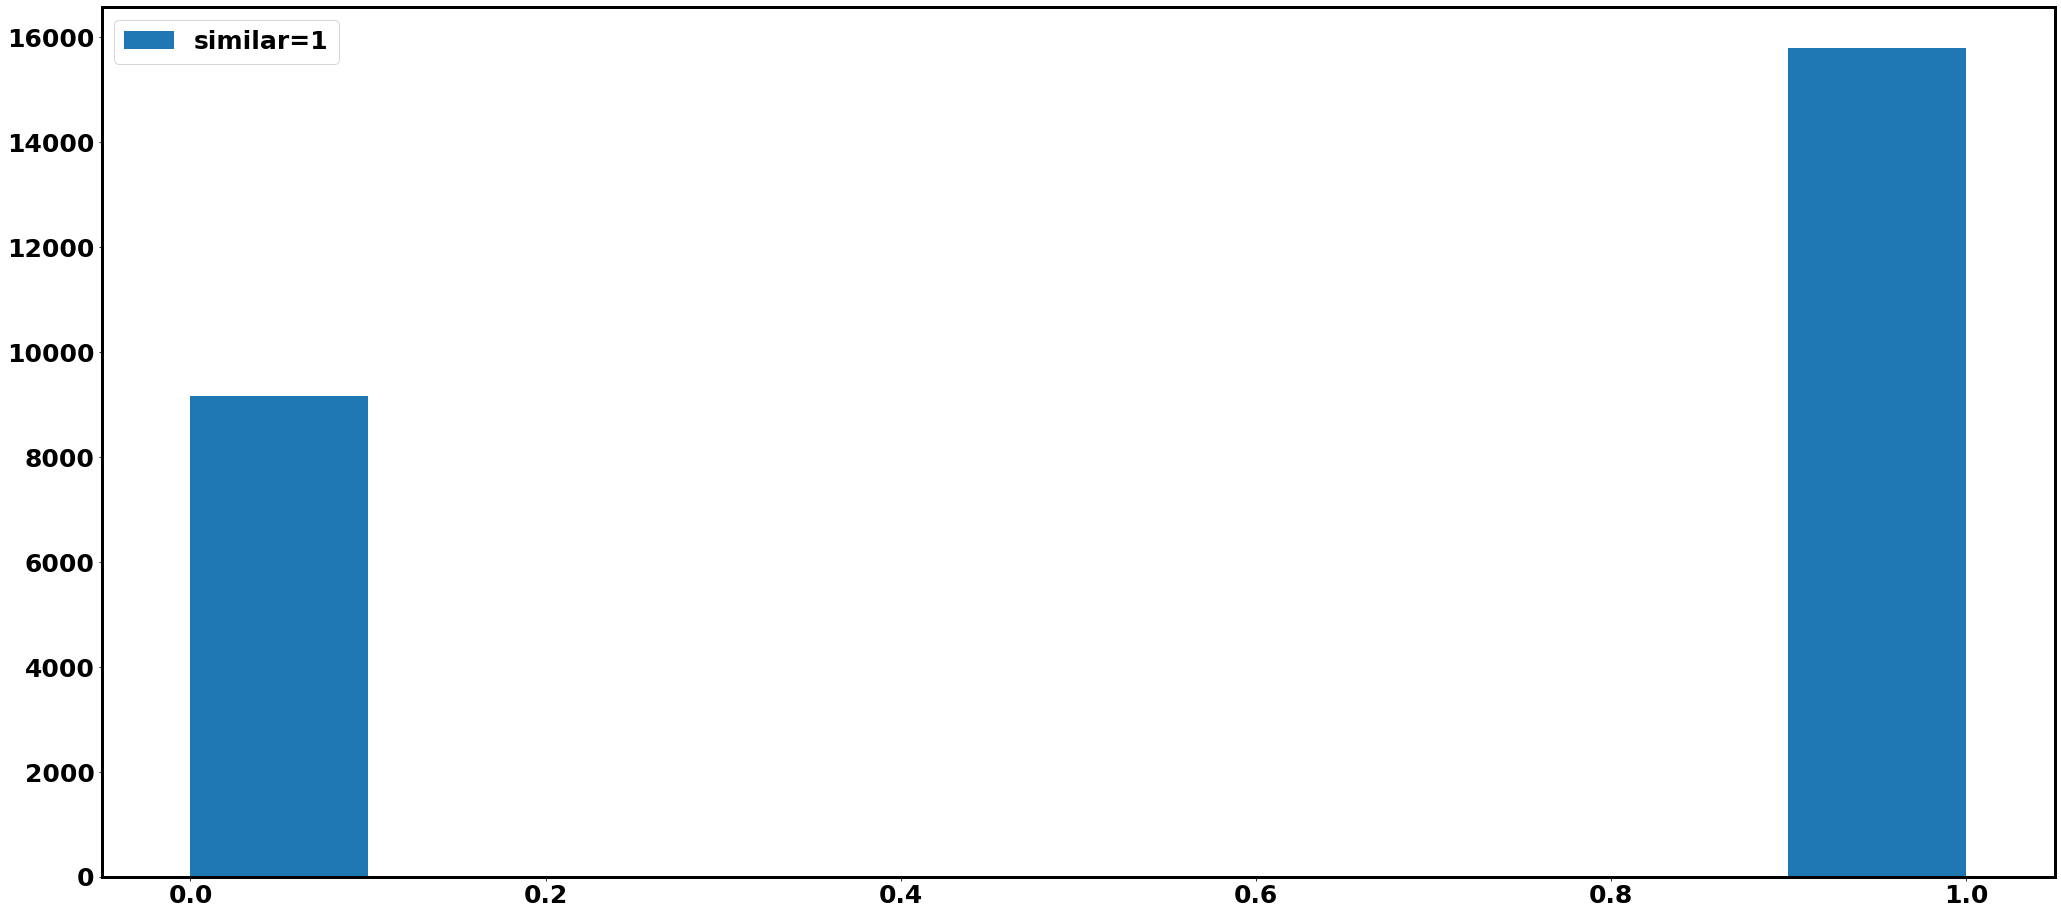

In [6]:

font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)

plt.hist(y,label="similar=1")

plt.legend()

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "labeled_y" + ".png"

fig.savefig(save_path, dpi=150)






findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


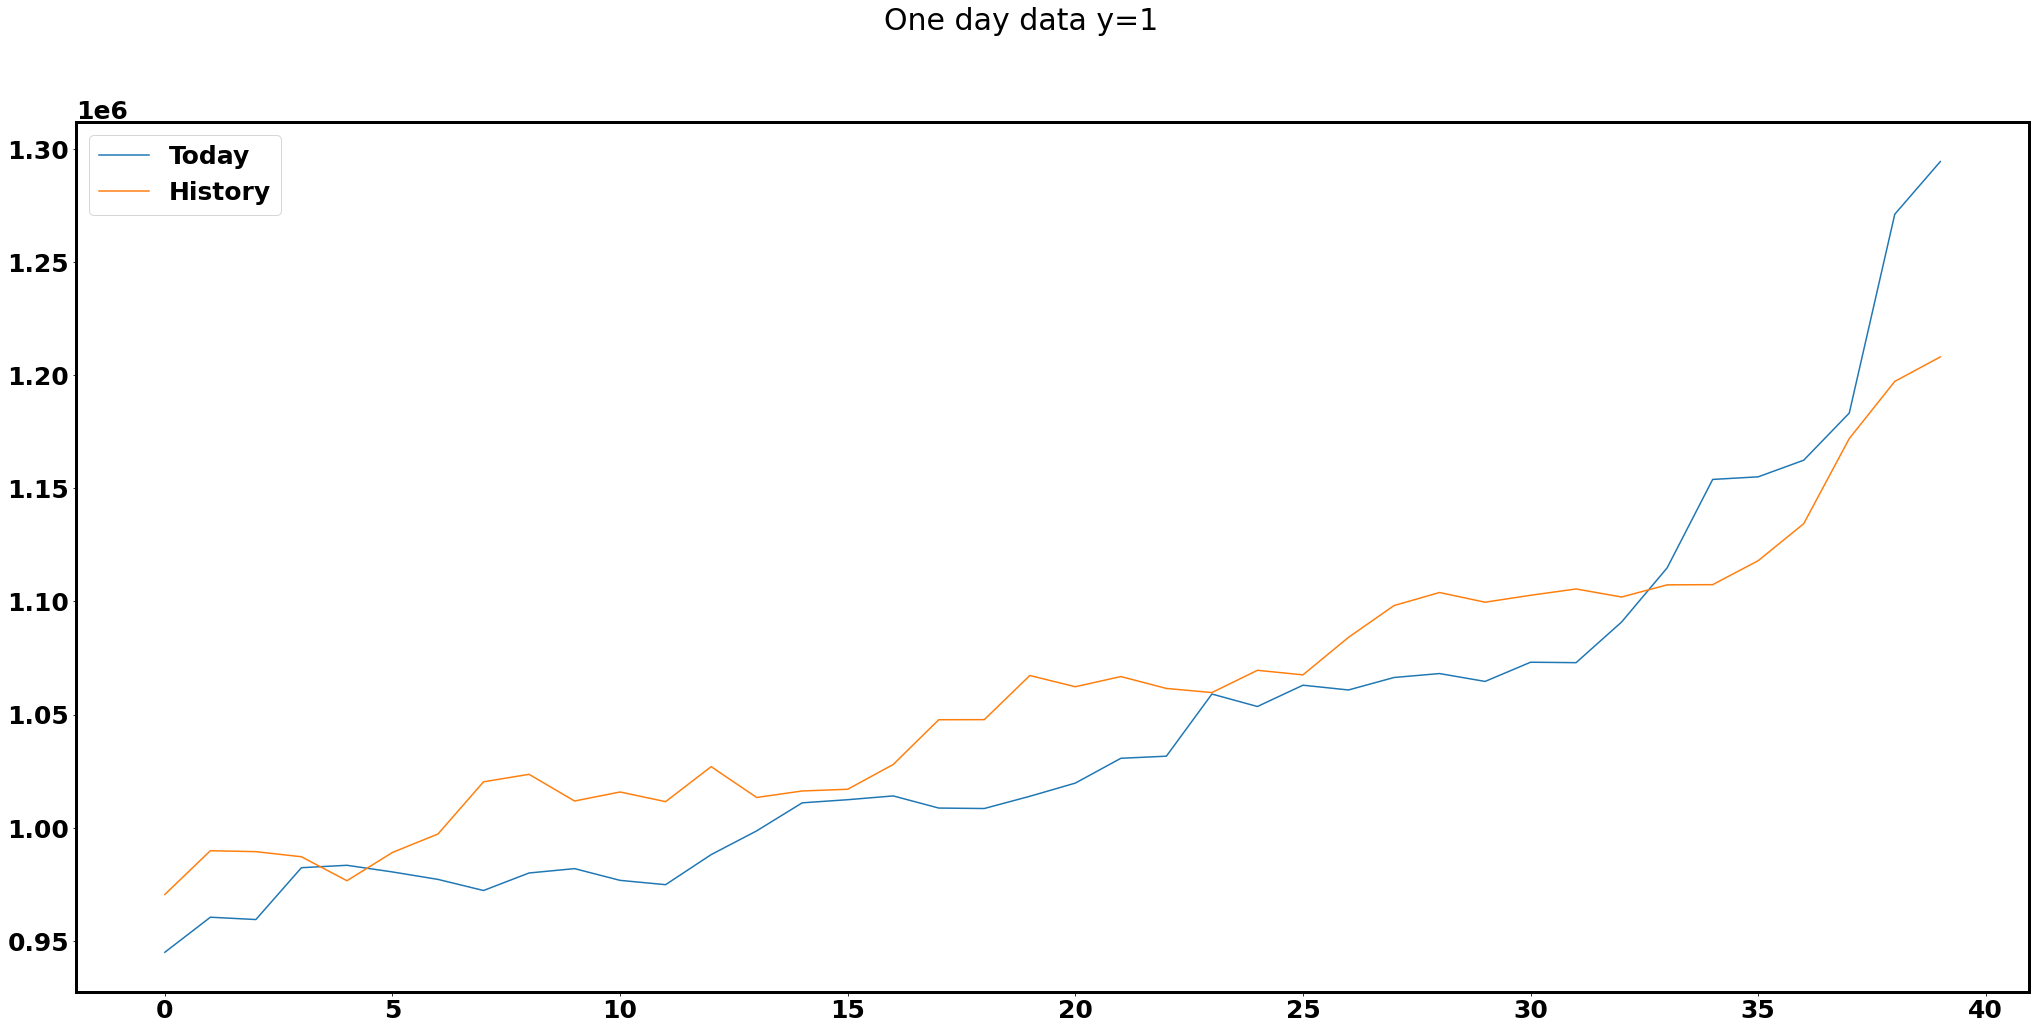

In [7]:



font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)

plt.plot(today[0,:],label = "Today")
plt.plot(history[0,:],label = "History")
plt.legend()
plt.suptitle("One day data y=%d"%y[0])

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "labeled_example" + ".png"

fig.savefig(save_path, dpi=150)




In [8]:
# scale dot attention:

import tensorflow as tf
import os

from sklearn import preprocessing

from sklearn.model_selection import train_test_split 




def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    # Dimension of k
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  
    # calculate attention weight:
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

# Multi-head Attention:
# This is what we use
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        
        # Always use Super to inheriatte and avoid extra code.
        assert d_model%num_heads==0
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        # sanity check:
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        # Q K W:
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
    def split_heads(self, x, batch_size):
        # Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        # https://www.tensorflow.org/api_docs/python/tf/transpose : perm
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        return output, attention_weights
    
    
        
        





In [9]:
## Encoder decoder for Time series:

# pointwise feed forward network
def point_wise_feed_forward_network(d_model, dff):
    # Two FC layers:
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

# Change embedding since it's not int anymore:
class EmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self,embedding_size):
        super(EmbeddingLayer,self).__init__()
        self.embedding_size=embedding_size

    def build(self,input_shape):
        with tf.name_scope('embedding'):
            self.shared_weights=self.add_weight(name='weights',
                                                shape=[input_shape[-1],self.embedding_size],
                                                initializer=tf.random_normal_initializer(mean=0.,
                                                                                         stddev=self.embedding_size ** -0.5))
        super(EmbeddingLayer,self).build(input_shape)


    def call(self,x):
        y=tf.einsum('bsf,fk->bsk',x,self.shared_weights)
        return y
    

class EncoderLayer(tf.keras.layers.Layer):
    # Here we use a 0.1 dropout rate as default
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
        return out2
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(tf.random.uniform((64, 43, 512)), False, None)

print(sample_encoder_layer_output.shape)  # (batch_size, input_seq_len, d_model)

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2





(64, 43, 512)


In [10]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                              np.arange(d_model)[np.newaxis, :],
                              d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
    
        # adding embedding and position encoding.
        #print("Check",x.shape)
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        #x = tf.keras.layers.Dense(self.d_model)(x)
        #print("check 2",x.shape)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        #print("check 3",x.shape)

        x = self.dropout(x, training=training)
        #print("check 4",x.shape)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x  # (batch_size, input_seq_len, d_model)
    
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        #x = tf.keras.layers.Dense(self.d_model)(x)
        
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights
    

In [11]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_seq_size, 
               output_seq_size, input_delta_t, output_delta_t, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_seq_size, input_delta_t, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               output_seq_size, output_delta_t, rate)
        
        # Now it output one cell: we ignore sigma for now and only miu

        #self.final_layer = tf.keras.layers.Dense(output_seq_size)
        # output there is 2 classes
        self.final_layer = tf.keras.layers.Dense(2)
        
        # Optional: Add sigma to model
        #self.final_layer_sigma = tf.keras.layers.Dense(1)


    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
        #print("check encoder size",enc_output.shape)

    
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        #print("check decoder size",dec_output.shape)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights





In [12]:
# sanity check:
# We encoder the float32 input to input_seq_size/output_seq_size integers
# The output is a sliding time table for different time scale prediction:
# Eg: you need to make sure your prediction delta_t<output delta_t and input data delta_t < input_delta_t
# For GTX 1060 we can set batch=16 and use 4X batch size for Tesla P40

batch = 8

sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_seq_size=1000, output_seq_size=1000, 
    input_delta_t=1440, output_delta_t=240)

# input: batch+sequence length
# biggest length for in/out put is pe_input,  pe_target
temp_input = tf.random.uniform((batch, 720), dtype=tf.int64, minval=0, maxval=1000)
temp_target = tf.random.uniform((batch, 3), dtype=tf.int64, minval=0, maxval=1000)

#temp_input = tf.cast(temp_input,dtype=tf.float32)
#temp_target = tf.cast(temp_target,dtype=tf.float32)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

print("final output size",fn_out.shape)  # (batch_size, tar_seq_len, target_vocab_size)



final output size (8, 3, 2)


In [13]:
# X: input : daily + history
# y: label

temp = X

# normalize first

temp = (temp - temp.min(axis=0)) / (temp.max(axis=0) - temp.min(axis=0))

lower, upper = 0, 999
temp = lower + (upper - lower) * temp
temp = np.array(temp,dtype=int)





findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


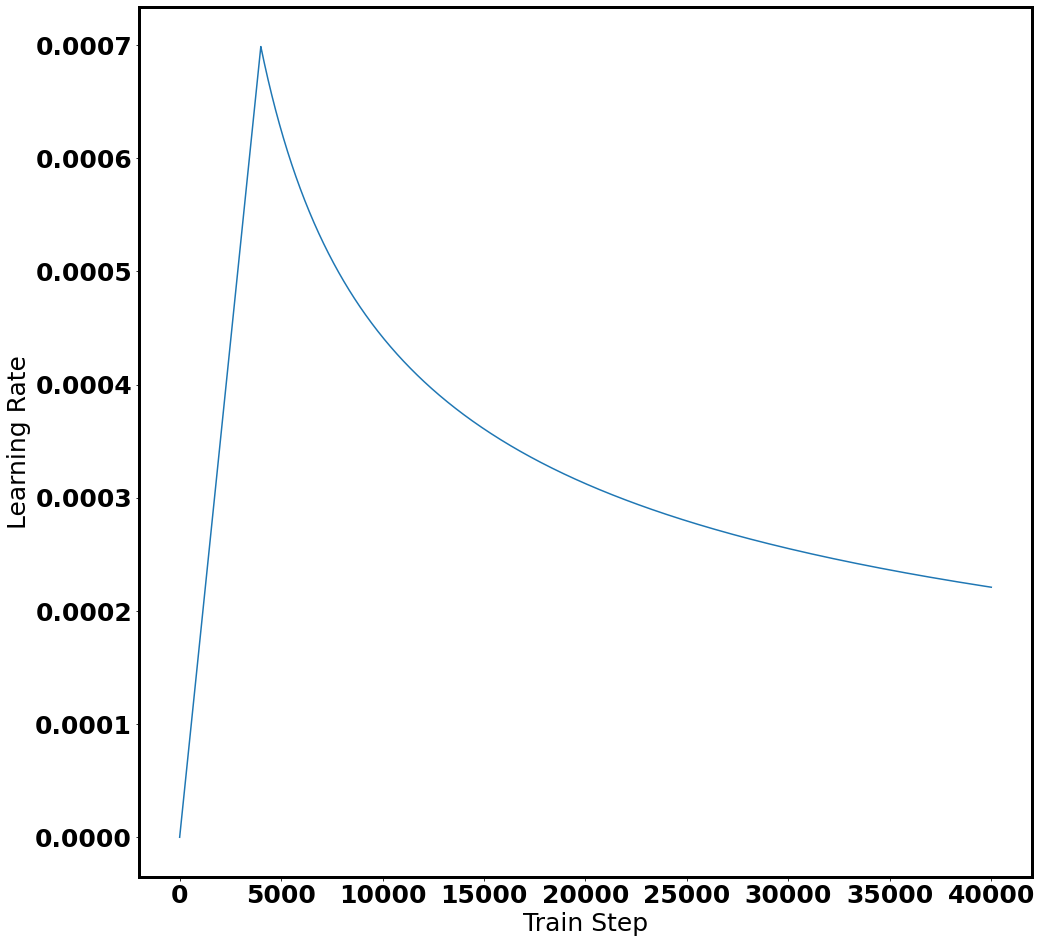

In [14]:
## Optimizor:
import matplotlib.pyplot as plt

d_model=512

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
    
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)
# Learning rate curve:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
fig = matplotlib.pyplot.gcf()

fig.set_size_inches(16,16)
plt.show()

In [15]:
# Loss function:
# loss and metric

# For now I use sparse-cross entropy. But MAE may make more sense here:

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    #mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    #mask = tf.cast(mask, dtype=loss_.dtype)
    #loss_ *= mask
  
    return tf.reduce_sum(loss_)



train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

# Optional
#train_accuracy = tf.keras.metrics.MeanSquaredError(name='train_MSE')








In [16]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

      
    return enc_padding_mask, combined_mask, dec_padding_mask

In [19]:




batch = 8

transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_seq_size=1000, output_seq_size=1000, 
    input_delta_t=800, output_delta_t=100)



# save file: optional
import os

checkpoint_path = "checkpoints/train_TS_classifier"
# os.system("mkdir %s"%checkpoint_path)

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')



train_step_signature = [
        tf.TensorSpec(shape=(None, None), dtype=tf.int64),
        tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    ]

@tf.function(input_signature=train_step_signature)

def train_step(inp, tar):
        
    tar_inp = tar
    tar_real = tar

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    with tf.GradientTape() as tape:
        # No mask for now : Optional
        enc_padding_mask, combined_mask, dec_padding_mask = None,None,None
        predictions, _ = transformer(inp, tar_inp, True, enc_padding_mask, combined_mask, dec_padding_mask)
        # predictions_id = tf.argmax(predictions, axis=-1)
        loss = loss_function(tar_real, predictions)

        
        ## Optional: Add MSE error term. Since the number in SCCE doesn't make sense. Add MSE to punish far away dots like 0 and 999
        #predictions_id = tf.argmax(predictions, axis=-1)
        #loss+=float(tf.reduce_sum(tf.keras.losses.MSE(tar,predictions_id))/(10000*batch))
        #value = float(tf.reduce_sum(tf.keras.losses.MSE(tar,predictions_id))/(1*batch))
        # Avoid gradient exploding
        """
        if not loss>0:
            value=float(100000)
        loss+=value
        
        """
        
        
        # Or we can only use MSE loss.
        
    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)













In [20]:



#Train and save:

# Here we use y=y+1



import time
X_train, X_test, y_train, y_test = train_test_split(np.atleast_3d(temp), y, test_size=0.3, shuffle=True)

EPOCHS = 3
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))

batch=64

N = len(y_train)

acc_array = []

for epoch in range(EPOCHS):
    start = time.time()
  
    train_loss.reset_states()
    train_accuracy.reset_states()
    for i in range(N//batch):
        inp, tar=X_train[batch*i:min(batch*i+batch,N),:,0],y_train[batch*i:min(batch*i+batch,N)]
        tar = np.atleast_2d(tar).T
        lo = train_step(inp, tar)
        acc_array.append(train_accuracy.result())
        if i%100==0 and epoch%1==0:
            # save:
            ckpt_save_path = ckpt_manager.save()
            
            # optional:
            # X_train, X_test, y_train, y_test = train_test_split(np.atleast_3d(temp), y, test_size=0.3, shuffle=True)
            
            print("Doing %d (%d) batch in epoch %d "%(i,N//batch,epoch))

            print("Loss",train_loss.result(), "accuracy",train_accuracy.result())
            

    
  

Doing 0 (272) batch in epoch 0 
Loss tf.Tensor(66.203186, shape=(), dtype=float32) accuracy tf.Tensor(0.3125, shape=(), dtype=float32)
Doing 100 (272) batch in epoch 0 
Loss tf.Tensor(4.9750137, shape=(), dtype=float32) accuracy tf.Tensor(0.9806621, shape=(), dtype=float32)
Doing 200 (272) batch in epoch 0 
Loss tf.Tensor(2.4998825, shape=(), dtype=float32) accuracy tf.Tensor(0.99028295, shape=(), dtype=float32)
Doing 0 (272) batch in epoch 2 
Loss tf.Tensor(0.0, shape=(), dtype=float32) accuracy tf.Tensor(1.0, shape=(), dtype=float32)
Doing 100 (272) batch in epoch 2 
Loss tf.Tensor(0.0, shape=(), dtype=float32) accuracy tf.Tensor(1.0, shape=(), dtype=float32)
Doing 200 (272) batch in epoch 2 
Loss tf.Tensor(0.0, shape=(), dtype=float32) accuracy tf.Tensor(1.0, shape=(), dtype=float32)


In [21]:
# testing:
#X_train, X_test, y_train, y_test = train_test_split(np.atleast_3d(temp), y, test_size=0.3, shuffle=True)
N_test = len(y_test)
prob_all = []


for i in range(N_test//batch):
    if i%50==0:
            print("Doing %d (%d)"%(i,N_test//batch))
    
    inp, tar=X_test[batch*i:min(batch*i+batch,N),:,0],y_test[batch*i:min(batch*i+batch,N)]
    tar = np.atleast_2d(tar).T
    tar_inp = tar
    tar_real = tar

    # enc_padding_mask, combined_mask, dec_padding_mask = None,None,None
    
    predictions, attention_weights = transformer(inp, 
                                                 tar,
                                                 False,
                                                 None,None,None)
    
    predictions_id = tf.argmax(predictions, axis=-1)
    
    if i==0:
        y_pred_all = predictions_id
        prob_all = predictions[:,0,:]
    else:
        y_pred_all = np.r_[y_pred_all,predictions_id]
        prob_all = np.r_[prob_all,predictions[:,0,:]]


    
y_pred_all = np.array(y_pred_all)

print("Train+Test all set!")

Doing 0 (116)
Doing 50 (116)
Doing 100 (116)
Train+Test all set!


In [22]:
y_pred_all = y_pred_all[:,0]
y_test = y_test[:len(y_pred_all)]

Y_predict_test = y_pred_all

mask_good = abs(Y_predict_test-y_test)<0.01

print("Good=%d Bad=%d"%(len(Y_predict_test[mask_good]),len(Y_predict_test)-len(Y_predict_test[mask_good])))

print("Accuracy=%.4f for testing set"%(len(Y_predict_test[mask_good])/len(Y_predict_test)))




Good=7424 Bad=0
Accuracy=1.0000 for testing set


In [23]:
def confusion_matrix(y_pred,y_true):
    TP = len(y_pred[(y_pred==1)&(y_true==1)])
    TN = len(y_pred[(y_pred==1)&(y_true==0)])
    # type1 error : false alarm
    FP = len(y_pred[(y_pred==1)&(y_true==0)])
    # type 2 error. Fail to make alarm
    FN = len(y_pred[(y_pred==0)&(y_true==1)])
    
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    accuracy = (TP+TN)/len(y_pred)
    
    f1_score = 2/(1/precision+1/recall)
    return TP,TN,FP,FN,recall,precision,accuracy,f1_score

te = confusion_matrix(y_pred=y_pred_all,y_true=y_test)
f1 = te[-1]
print("F1 score=%.4f"%f1)

F1 score=1.0000


AUROC: 1.0000


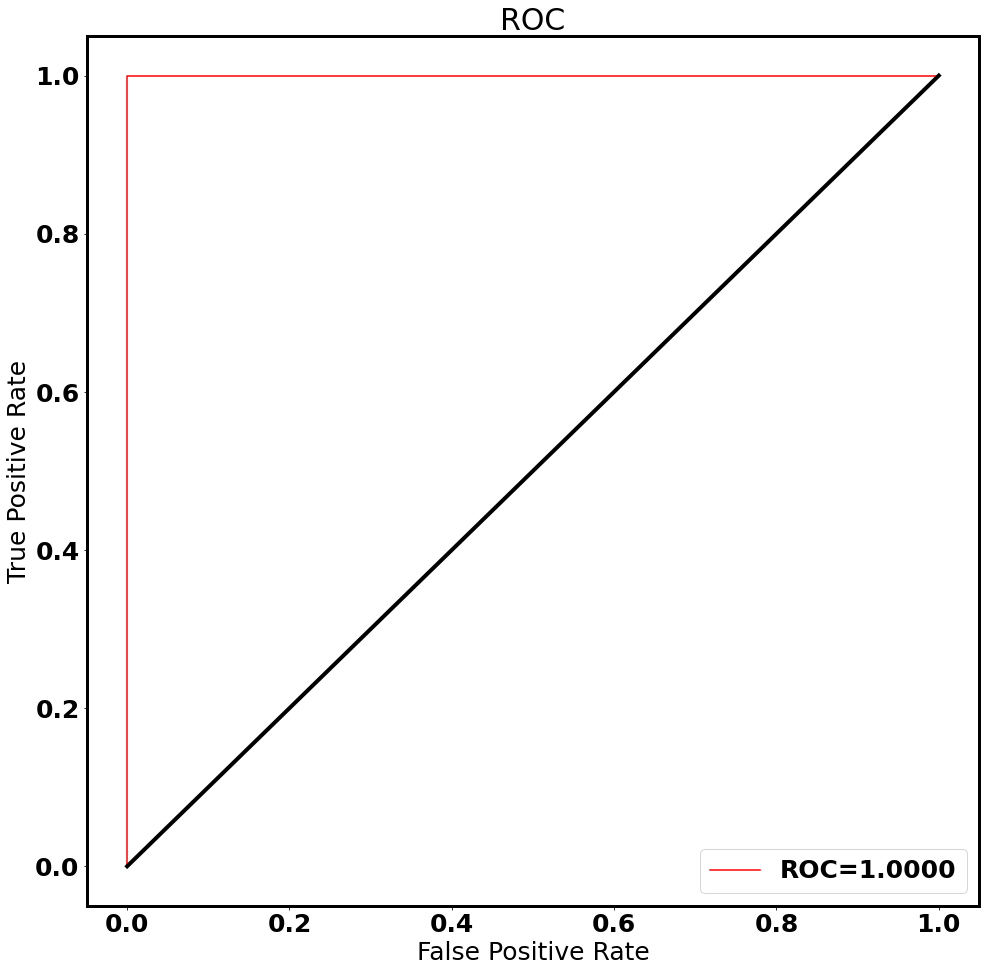

In [24]:

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


testy = y_test

probs = prob_all[:,1]



auc = roc_auc_score(testy, probs)
print('AUROC: %.4f' % auc)

## draw ROC:
fpr, tpr, thresholds = roc_curve(testy, probs)

font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


plt.plot(fpr, tpr, color='r', label='ROC=%.4f'%auc)
plt.plot([0, 1], [0, 1], color='k',linewidth=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
fig = matplotlib.pyplot.gcf()


fig.set_size_inches(16,16)
save_path = plot_path + "labeled_AUROC_Transformer" + ".png"

fig.savefig(save_path, dpi=150)






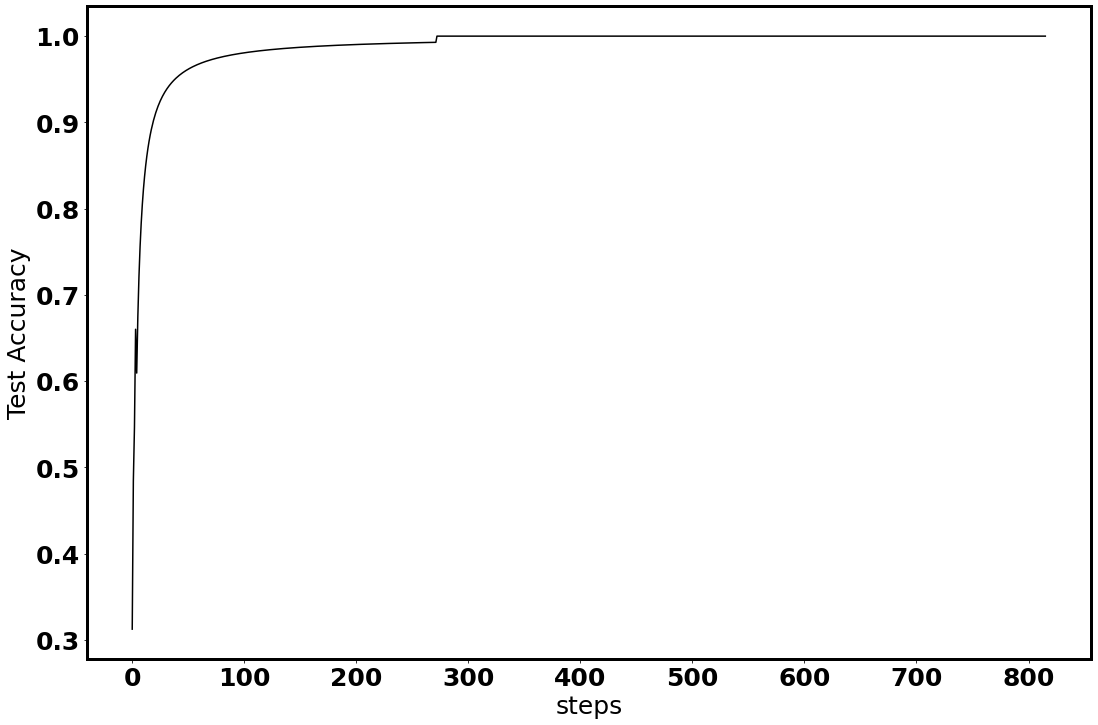

In [25]:

font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)



plt.plot(acc_array,"k")

plt.xlabel('steps')
plt.ylabel('Test Accuracy')

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(18,12)

save_path = plot_path + "Test_acc_Transformer" + ".png"

fig.savefig(save_path, dpi=150)

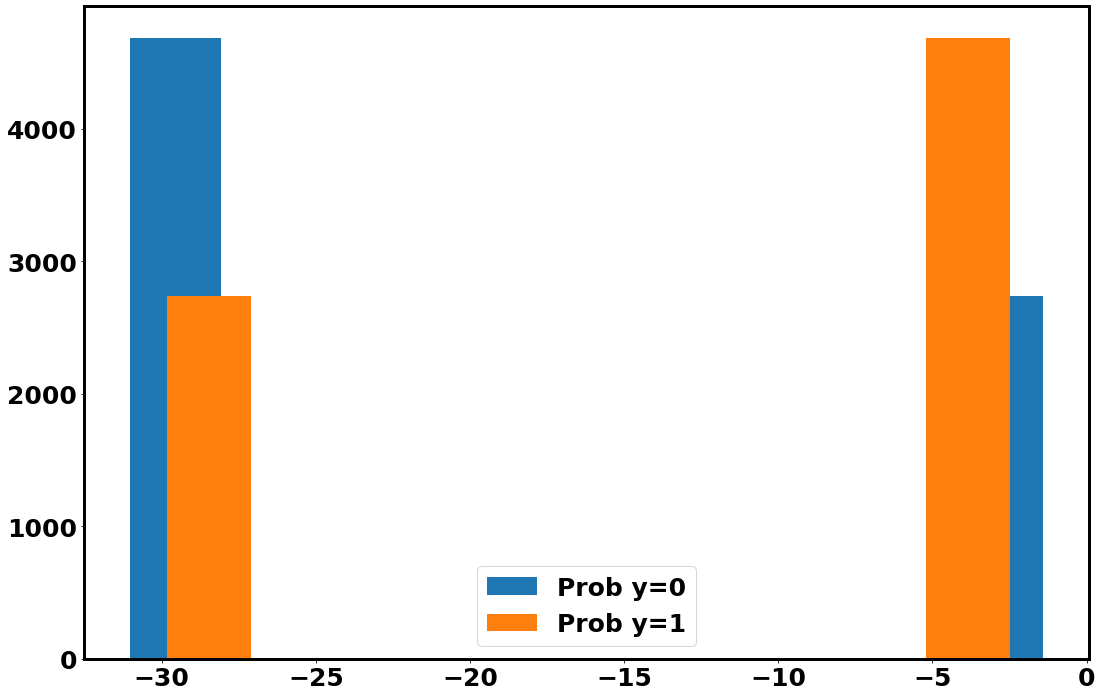

In [26]:

font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)



plt.hist(prob_all[:,0],label="Prob y=0")
plt.hist(prob_all[:,1],label="Prob y=1")
plt.legend()
fig = matplotlib.pyplot.gcf()


fig.set_size_inches(18,12)

save_path = plot_path + "Test_prob_Transformer" + ".png"

fig.savefig(save_path, dpi=150)



# Try GAN to generate data sets:


In [56]:
# two channels
temp = np.dstack((today,history))
temp.shape

(24948, 40, 2)

In [120]:
from tensorflow.keras import layers
from keras.models import Model

from keras.layers import Input, Dense, LSTM, multiply, concatenate, Activation, Masking, Reshape
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout
size=temp.shape[1]
latent_dim = 2000

# Our goal is to use GAN to generate fake labeled data:
# This is a simple CNN+Dense layer structure


def squeeze_excite_block(input):

    filters = input._shape[-1] # channel_axis = -1 for TF

    se = GlobalAveragePooling1D()(input)
    se = Reshape((1, filters))(se)
    se = Dense(filters // 16,  activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    se = multiply([input, se])
    return se

def Generator(latent_dim,size):
    seed = Input(shape=(latent_dim,2))

    y = Permute((2, 1))(seed)

    y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)

    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)

    y = Conv1D(size, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    out=tf.transpose(y, [0,2,1])
    
    model = Model(seed, out)

    #model.summary()

    # add load model code here to fine-tune

    return model



# summary of the generator
generator = Generator(latent_dim,size)
generator.summary()

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 2000, 2)]    0                                            
__________________________________________________________________________________________________
permute_26 (Permute)            (None, 2, 2000)      0           input_31[0][0]                   
__________________________________________________________________________________________________
conv1d_55 (Conv1D)              (None, 2, 128)       2048128     permute_26[0][0]                 
__________________________________________________________________________________________________
batch_normalization_55 (BatchNo (None, 2, 128)       512         conv1d_55[0][0]                  
___________________________________________________________________________________________

In [121]:
# batch size=3
#import gc
#gc.collect()
noise = tf.random.normal([3,latent_dim,2])

generator(noise, training=False).shape

TensorShape([3, 40, 2])

In [122]:
def discriminator():
    ip = Input(shape=(size,2))
    y = Permute((2, 1))(ip)
    #print(y.shape)
    y = Conv1D(64, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    
    y = Conv1D(32, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    
    
    
    y = GlobalAveragePooling1D()(y)
    #print(y.shape)
    out=Dense(1)(y)
    #print(out.shape)
    
    model = Model(ip, out)
    
    
    return model



In [123]:
discriminator = discriminator()
discriminator.summary()


Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 40, 2)]      0                                            
__________________________________________________________________________________________________
permute_27 (Permute)            (None, 2, 40)        0           input_32[0][0]                   
__________________________________________________________________________________________________
conv1d_58 (Conv1D)              (None, 2, 64)        7744        permute_27[0][0]                 
__________________________________________________________________________________________________
batch_normalization_58 (BatchNo (None, 2, 64)        256         conv1d_58[0][0]                  
___________________________________________________________________________________________

In [124]:
discriminator(temp[:4,:,:]).shape

TensorShape([4, 1])

In [125]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    # compare real_image_output 
    # Here 1 is real, so we compare "real" for real output" to evaluate how well the discriminator can tell it's real
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # compare fake_image_output: Zero means false and vice versa
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # tot
    total_loss = real_loss + fake_loss
    return total_loss

# generator loss:
# Let's tell how well the generator can "trick" the discriminator
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


# define optimizer for both the generator and discriminator: use adam
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#%%

# check points:
checkpoint_dir = 'checkpoints/checkpoints_GAN.ckpt'
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


#%%

# epochs and batch_size
n_epochs = 20
batch_size=64


In [126]:
## Treat input as images:
noise_dim = latent_dim
def train(image_batch):
    # print("Doing %d epoch of %d epoch" % (epoch, n_epochs))

    # GradientTape: automatically calculate the gradient of a computation with respect to its input variables
    # The generator start with noise
    noise = tf.random.normal([batch_size, noise_dim,2])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(image_batch, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # The gradient
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # optimize the gradient
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss,disc_loss
        


In [ ]:

mask_1 = y==1


X_train, X_test, y_train, y_test = train_test_split(np.atleast_3d(temp)[mask_1], y[mask_1], test_size=0.3, shuffle=True)



print("Start training")
## Let's train it:
for epoch in range(n_epochs):
    # print("Doing %d of %d epoch"%(epoch,n_epochs))
    start = time.time()
    count=0
    for i in range(N//batch):
        
        inp=X_train[batch*i:min(batch_size*i+batch_size,N),:,:]
        
        gen_loss,disc_loss=train(inp)
    
        if i%30==0 and epoch%5==0:
            # optional save:
            # ckpt_save_path = ckpt_manager.save()
            
            # Optional shuffle:
            # X_train, X_test, y_train, y_test = train_test_split(np.atleast_3d(temp)[mask_1], y[mask_1], test_size=0.3, shuffle=True)
            print("Doing %d (%d) batch in epoch %d "%(i,N//batch,epoch))

            print("Generator loss=%.2f Discriminator loss=%.2f"%(gen_loss,disc_loss))
        
        count+=1

    #save:


print("Finish training!")

In [ ]:
# Generate something for y=1 :)

batch_test=32
N_gen = 100

noise = tf.random.normal([batch_test,latent_dim,2])
generated_images_i = generator(noise, training=False)
    

In [ ]:
i=3
plt.plot(generated_images_i[i,:,0],"r",label="Today")
plt.plot(generated_images_i[i,:,1],"b",label="History")

In [133]:
print("Done")

Done
